This method writes and tests methods to calculated integrated watervapor transport (IVT) and integrated watervapor path (IWV).  Following, [Rutz, J. J., W. J. Steenburgh, and F. M. Ralph, 2014: Climatological Characteristics of Atmospheric Rivers and Their Inland Penetration over the Western United States. Mon. Weather Rev., 142, 905–921, doi:10.1175/MWR-D-13-00168.1](http://dx.doi.org/10.1175/MWR-D-13-00168.1), these are calculated as:

$$IWV = -\frac{1}{g} \int\limits^{p_s}_0 q dp$$

$$|IVT| = \left| -\frac{1}{g} \int\limits^{p_s}_0 q \vec{U} dp \right| $$

In [1]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import matplotlib as mpl
import netCDF4 as nc
import glob
import datetime as dt
import sys
import os
from mpl_toolkits.basemap import Basemap, cm

import scipy.optimize
import numpy as np

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

import os; print("{}:{}".format('cori',os.getcwd()))

cori:/global/project/projectdirs/m1517/cascade/taobrien/csheilds_ar_landfall_lats_code/teca_test_data


In [2]:
""" Read in the IWV/IVT components from a sample MERRA file """
test_file = "ARTMIP_MERRA_3D_20170201_00.nc"

with nc.Dataset(test_file) as fin:
    q = fin.variables['QV'][:]
    u = fin.variables['u'][:]
    v = fin.variables['v'][:]
    pressure = fin.variables['lev'][:]
    lat = fin.variables['lat'][:]
    lon = fin.variables['lon'][:]

In [3]:
""" Define a vertical integral function """
import scipy.integrate # import the scipy integration library

def calculate_pressure_integral(integrand, pressure):
    """ Calculates the vertical integral (in pressure coordinates) of an array
    
        input:
        ------
            integrand     : the quantity to integrate.  The vertical dimension is assumed to be the first index.
            
            pressure      : the pressure (either a vector or an array of the same shape as integrand).  Units should be [Pa].
            
        output:
        -------
        
            integral      : the approximated integral of integrand (same shape as integrand, but missing the leftmost
                            dimension of integrand).
                            
            For integrand $F(p)$, this function approximates
            
            $$ -\frac{1}{g} \int\limits^{p_s}_0 F(p) dp $$
            
    """
    # set necessary constants
    one_over_negative_g = -1./9.80665 # m/s^2
    
    # determine whether pressure needs to be broadcast to the same shape as integrand
    # check if the dimensions of integrand and pressure don't match
    if not all( [s1 == s2 for s1,s2 in zip(integrand.shape,pressure.shape)] ):
        
        # try broadcasting pressure to the proper shape
        try:
            pressure3d = np.ones(integrand.shape)*pressure[:,np.newaxis,np.newaxis]
        except:
            raise ValueError("pressure cannot be broadcast to the shape of integrand. shape(pressure) = {}, and shape(integrand) = {}".format(pressure.shape,integrand.shape))
    
    # if they do, then simply set pressure3d to pressure
    else:
        pressure3d = pressure
        
    
    # calculate the integral
    # ( fill in any missing values with 0)
    integral = scipy.integrate.simps(np.ma.filled(integrand,0),pressure,axis=0)
    
    # scale the integral and return
    return one_over_negative_g*integral

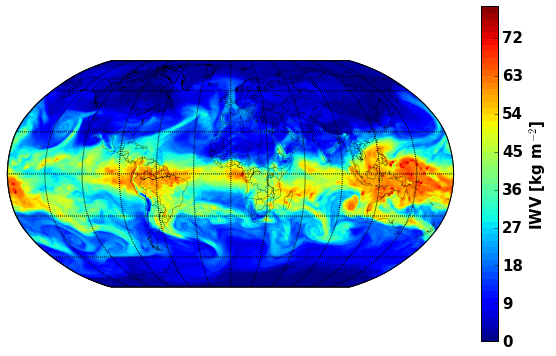

In [4]:
""" Calculate IWV and plot """

# calculate integrated water vapor path [kg/m^2]
# note that
IWV = calculate_pressure_integral(q,pressure*100)

# plot it

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0.5*(lon[0]+lon[-1]),resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,IWV,64,latlon=True)

fig.colorbar(cs,ax=ax,label='IWV [kg m$^{-2}$]')
PP.show()

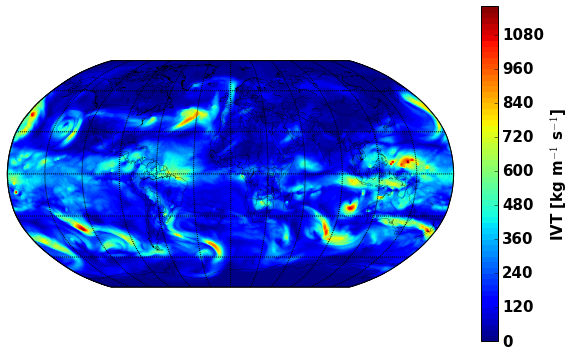

In [5]:
""" Calculate IVT and plot """

# calculate integrated water vapor path [kg/m^2]
# note that
IVT_u = calculate_pressure_integral(q*u,pressure*100)
IVT_v = calculate_pressure_integral(q*v,pressure*100)
IVT = np.sqrt(IVT_u**2 + IVT_v**2)

# plot it

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0.5*(lon[0]+lon[-1]),resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,IVT,64,latlon=True)

fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()

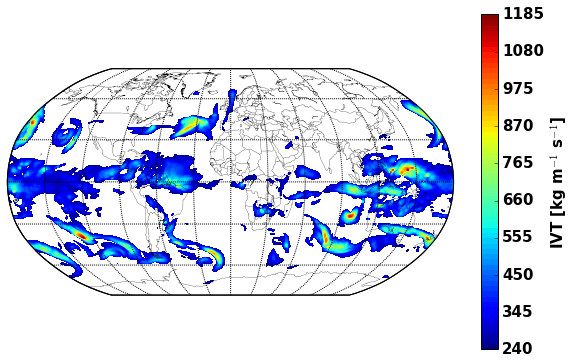

In [6]:
""" Replot IVT, but remove regions below 250 kg/m/s """
IVT_masked = np.ma.masked_less(IVT,250)

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0.5*(lon[0]+lon[-1]),resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,IVT_masked,64,latlon=True)

fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()

The above plots seem reasonable.  IWV values in the midlatitudes peak in the 40 kg/m$^2$ range (40 mm of water), which is consistent with Rutz et al.  IVT values in the midlatitudes peak in the 600 kg/m/s range, which is also consistent with Rutz et al.